In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

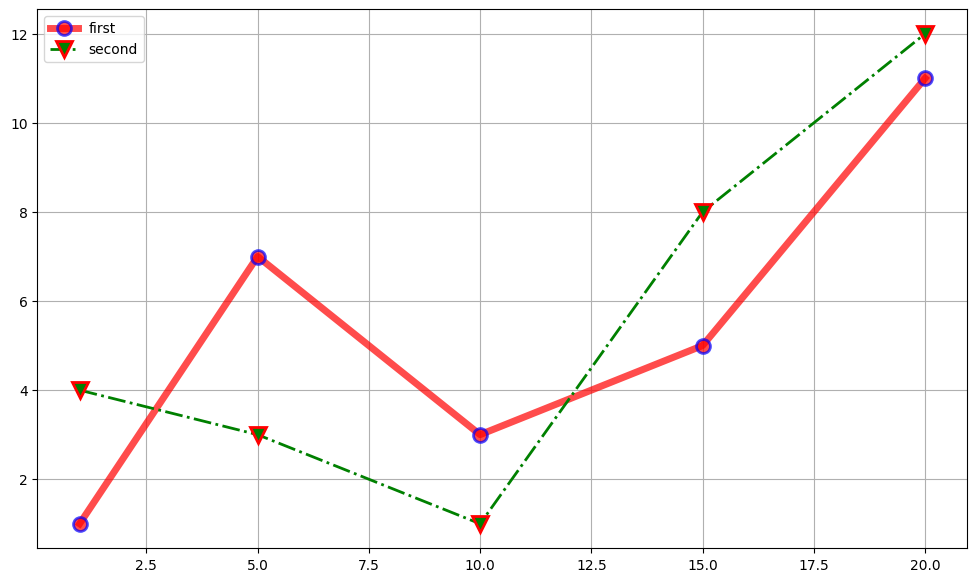

In [2]:
x = [1, 5, 10, 15, 20]
y1 = [1, 7, 3, 5, 11]
y2 = [4, 3, 1, 8, 12]
plt.figure(figsize=(12, 7))
plt.plot(x, y1, 'o-r', alpha=0.7, label="first", lw=5, mec='b', mew=2, ms=10)
plt.plot(x, y2, 'v-.g', label="second", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

In [3]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical
from torchmetrics.text import WordErrorRate
from torchvision.io import read_image
from torchvision.models import MobileNet_V2_Weights, mobilenet_v2
from torchvision.models import EfficientNet_V2_M_Weights, efficientnet_v2_m, EfficientNet_V2_S_Weights, efficientnet_v2_s
import numpy as np
import shutil
from collections import defaultdict
from functools import partial
from itertools import chain
import os
import json
import copy
import typing
from typing import Optional
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sacrebleu import corpus_bleu
from collections import defaultdict
from accelerate import Accelerator
from PIL import Image
import re
import math

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers.processors import TemplateProcessing

os.environ["TOKENIZERS_PARALLELISM"] = "true"

C:\Users\sofi\AppData\Roaming\Python\Python39\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\sofi\AppData\Roaming\Python\Python39\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
# фиксации параметров в рамках всего запуска
def seed_everything(seed: int) -> None:
    import os
    import random
    import torch
    import numpy as np

    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


def seed_worker(worker_id):
    import random
    import numpy as np
    import torch
    
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

SEED = 13
seed_everything(SEED)

import torch
g = torch.Generator()
g.manual_seed(0)

# accelerator = Accelerator(mixed_precision="no", cpu=True)
accelerator = Accelerator(mixed_precision="no")

device = accelerator.device
print(device)

cuda


In [5]:
def get_target(data_dir: Path,
               le: typing.Optional[LabelEncoder] = None,
               label_encoder_pickle_file: Path = Path.cwd() / "data" / "labelencoder.pkl",
               feedbacks : bool = True,
               level : int = 1,
               category1: str = None,
               category2: str = None,
               category3: str = None,
               category4: str = None,
               ):

    folders = os.listdir(data_dir)
    
    if level not in range(1,6):
        raise ValueError("The value of 'level' must be 1, 2, 3, 4 or 5")
    
    if level == 1:
        categories = folders

    elif level == 2:
        if category1 is None:
            raise TypeError("choose_category() missing 1 required positional argument: 'category1'")
        categories = [category for category in folders if category.split("_")[0]==category1]

    elif level == 3:
        if category1 is None or category2 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1' or 'category2'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2)]

    elif level == 4:
        if category1 is None or category2 is None or category3 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1', 'category2' or 'category3'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2) and (category.split("_")[2]==category3)]

    elif level == 5:
        if category1 is None or category2 is None or category3 is None  or category4 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1', 'category2', 'category3' or 'category4'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2) and (category.split("_")[2]==category3) and (category.split("_")[3]==category4)]
    
    if feedbacks:
        paths_card = [data_dir / category / "card" for category in categories]
        paths_feedbacks = [data_dir / category / "feedbacks" for category in categories]
        img_paths = [sorted(sub_category.rglob("*.png")) for sub_category in paths_card + paths_feedbacks]
        img_paths = list(chain(*img_paths))
    else:
        paths_card = [data_dir / category / "card" for category in categories]
        img_paths = [sorted(sub_category.rglob("*.png")) for sub_category in paths_card]
        img_paths = list(chain(*img_paths))
    
    target = ["_".join(path.parts[-3:-2][0].split("_")[:level]) for path in img_paths]
    if level != 1:
        model_name = "_".join(target[0].split("_")[:level-1])
    else:
        model_name = "full_model"
    
    if not le:
        le = LabelEncoder()
        le = le.fit(target)

    target_enc = le.transform(target)

    # Соотнесения закодированного таргета и названий категорий
    dict_topic = dict(zip(target, target_enc))
    target2idx = dict(sorted(dict_topic.items(), key=lambda item: item[1]))
    idx2target = dict(zip(target_enc, target))

    return img_paths, torch.from_numpy(target_enc).long(), target2idx, idx2target


def get_traintestsplit(categories : list[str],
                       data_dir : Path,
                       SEED : int,
                       feedbacks : bool = False,
                       ):
    
    full_train_paths, full_test_paths = [], []
    for cat in categories:
        img_paths, target_enc, _, _ = get_target(data_dir,
                                                 feedbacks=False,
                                                 level=2,
                                                 category1=cat)

        train_paths, test_paths, _, _ = train_test_split(img_paths, target_enc,
                                                         test_size=0.2,
                                                         stratify=target_enc,
                                                         random_state=SEED)
        
        full_train_paths.extend(train_paths)
        full_test_paths.extend(test_paths)
        
    return full_train_paths, full_test_paths

In [6]:
from tokenizers.models import WordLevel, WordPiece
from tokenizers.trainers import WordLevelTrainer, WordPieceTrainer

In [7]:
def delete_none_items(paths: list[Path],
                      descriptions: pd.DataFrame,
                      embeddings: torch.Tensor):
    
    descriptions.reset_index(inplace=True)
    ind_isna = descriptions[descriptions["description"].isna()].index.tolist()
    ind_notna = descriptions[descriptions["description"].notna()].index.tolist()
    
    # удаление
    descriptions.drop(index=ind_isna, inplace=True)
    descriptions.reset_index(inplace=True)
    paths = list(pd.DataFrame(paths, columns=["paths"]).drop(index=ind_isna)["paths"])
    embeddings = torch.index_select(embeddings, dim=0, index=torch.from_numpy(np.array(ind_notna)))
    
    return paths, descriptions, embeddings


def text_prepocessing(text: str) -> str:
    text = text.lower()
#     text = re.sub(r"[^0-9a-zA-Zа-яА-ЯёЁ]", " ", text)
    text = re.sub(r"\s+", " ", text)    
    return text


def get_descriptions_and_embeds(paths: list[Path]):
    descriptions = []
    embeddings_check = False
    
    for path in paths:
        line = pd.read_csv(path.parents[1] / "descriptions.csv", index_col="item").loc[path.name]
        descriptions.append(line)
        
        embed = pd.read_csv(path.parents[1] / "embeddings.csv", index_col="item").loc[path.name]["embedding"].encode().decode('unicode-escape').encode('ISO-8859-1')[2:-1]
        embed = torch.from_numpy(np.copy(np.frombuffer(embed, dtype=np.float32))).view(1, -1)
        if embeddings_check:
            embeddings = torch.cat([embeddings, embed], dim=0)
        else:
            embeddings = torch.cat([embed], dim=0)
            embeddings_check = True
        
        
    df = pd.DataFrame(descriptions)
    paths, df, embeddings = delete_none_items(paths, df, embeddings)
    df['descriptions_preproc'] = df.description.apply(text_prepocessing)
    return df, embeddings, paths


def get_tokenizer(df_descriptions, saving : bool = False):
    tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = Whitespace()
    trainer = WordLevelTrainer(special_tokens=["[PAD]", "[BOS]", "[EOS]", "[UNK]"])

    # обучение
    tokenizer.train_from_iterator(df_descriptions["descriptions_preproc"], trainer=trainer)
    
    # создаем шаблон, как надо выдавать предложения
    tokenizer.post_processor = TemplateProcessing(
        single="[BOS] $A [EOS]",
        special_tokens=[
            ("[BOS]", tokenizer.token_to_id("[BOS]")),
            ("[EOS]", tokenizer.token_to_id("[EOS]")),
        ],
    )
    
    if saving:
        # сохранили в файл
        tokenizer.save("tokenizer.json") 
    
    return tokenizer

In [8]:
#tokenizer.token_to_id("[PAD]")
#tokenizer.encode("маша мыла раму. петя пишет AAA там тут и сям. +").ids

In [9]:
data_dir = Path("C:/temp/!hse-mlds-project-year2") / "data_embed_test"

# в данной функции определяется надо ли исп-ть feedbacks и какие категории брать
img_paths, target_enc, target2idx, idx2target = get_target(data_dir,
                                                  feedbacks=False,
                                                  level=1,
                                                  category1="Обувь",
                                                  category2="Детская&электроника")
train_paths, test_paths = get_traintestsplit(categories=sorted(target2idx.keys()),
                                             data_dir=data_dir,
                                             SEED=SEED)
print(len(train_paths), len(test_paths))

335 84


In [10]:
descriptions_train, embeddings_train, train_paths = get_descriptions_and_embeds(train_paths)
descriptions_test, embeddings_test, test_paths = get_descriptions_and_embeds(test_paths)

tokenizer = get_tokenizer(descriptions_train)
print(tokenizer.get_vocab_size())                       # посмотрим на размер словаря

descriptions_train

6784


,level_0,index,description,descriptions_preproc
0,0,1.png,Уважаемые покупатели! В фотографиях представле...,уважаемые покупатели! в фотографиях представле...
1,1,3.png,Классические туфли и лоферы – эти модели должн...,классические туфли и лоферы – эти модели должн...
2,2,15.png,Ботинки челси для девочки подростка на небольн...,ботинки челси для девочки подростка на небольн...
3,3,2.png,Классические демисезонные кроссовки – это попу...,классические демисезонные кроссовки – это попу...
4,4,17.png,"Маломерят, внимательно выбирайте размер!\nНаша...","маломерят, внимательно выбирайте размер! наша ..."
...,...,...,...,...
328,330,0.png,Женские короткие резиновые сапоги выполнены в...,женские короткие резиновые сапоги выполнены в...
329,331,1.png,Открытые сандалии это комфортная обувь весной ...,открытые сандалии это комфортная обувь весной ...
330,332,2.png,Стильные женские балетки на прорезиненной подо...,стильные женские балетки на прорезиненной подо...
331,333,9.png,Не спешите писать негативный отзыв при следующ...,не спешите писать негативный отзыв при следующ...


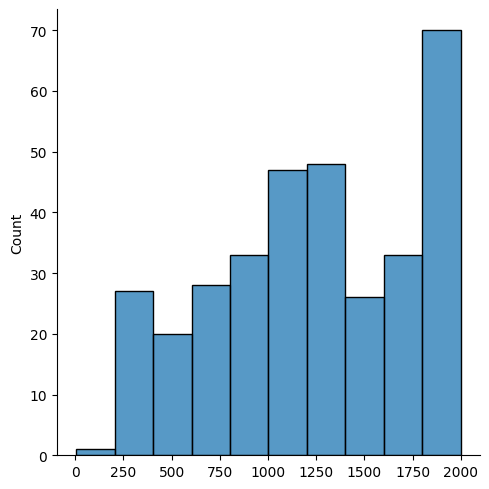

In [11]:
#Посмотрим на длину последоватеьностей
_ = sns.displot([len(sent) for sent in descriptions_train["descriptions_preproc"]])

In [12]:
class WbDataset(Dataset):
    def __init__(self,
                 img_paths: list[Path],
                 img_embeds: torch.Tensor,
                 descriptions: list[str],
                 tokenizer: Tokenizer,
                 max_length: int = 5000,
                ):

        self.img_paths = img_paths
        self.img_embeds = img_embeds
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.descriptions = descriptions
        
    def __getitem__(self, index):
        img_path = self.img_paths[index]

        ids = self.tokenizer.encode(self.descriptions[index]).ids[:self.max_length]
        out = {"embed": self.img_embeds[index], "description": ids, "path": str(img_path)}
 
        return out


    def __len__(self):
        return len(self.img_embeds)

In [13]:
train_dataset = WbDataset(img_paths=train_paths,
                          img_embeds=embeddings_train,
                          descriptions=descriptions_train["descriptions_preproc"],
                          tokenizer=tokenizer,
                         )

test_dataset = WbDataset(img_paths=test_paths,
                         img_embeds=embeddings_test,
                         descriptions=descriptions_test["descriptions_preproc"],
                         tokenizer=tokenizer,
                         )

In [14]:
item = train_dataset[0]

print(item.keys())
print(item["embed"].shape)
print(len(item["description"]))
print(len(tokenizer.decode(item["description"]).split()))

dict_keys(['embed', 'description', 'path'])
torch.Size([1024])
234
232


In [15]:
#tokenizer.get_vocab()

In [16]:
class Collator:
    def __init__(self, transform=None, mixes=None) -> None:
        self.transform = transform
        self.mixes = mixes

    def __call__(self, batch):
        tensor_dict = defaultdict(list)
        for sample in batch:
            for key, value in sample.items():
                tensor_dict[key].append(value)

        data = torch.stack(tensor_dict["embed"])
        
        # Pad values
        out = {
            "embed": data,
            "description": pad_sequence([torch.tensor(t) for t in tensor_dict["description"]], batch_first=True),
            "path": tensor_dict["path"],
        }

        return out

In [17]:
# train_dataset = torch.utils.data.Subset(train_dataset, [i for i in range(8)])
# test_dataset = torch.utils.data.Subset(test_dataset, [i for i in range(8)])
BATCH_SIZE = 16

train_loader = accelerator.prepare_data_loader(DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               collate_fn=Collator(),
                                               pin_memory=True,
                                               generator=torch.Generator().manual_seed(SEED),
                                               worker_init_fn=seed_worker)
                                                                  )


val_loader = accelerator.prepare_data_loader(DataLoader(test_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             collate_fn=Collator(),
                                             pin_memory=True,
                                             generator=torch.Generator().manual_seed(SEED),
                                             worker_init_fn=seed_worker)
                                                                )

In [18]:
elem = next(iter(train_loader))
#elem['img'][0].shape

# visualise_1pic(elem[0][0])

In [19]:
elem["embed"].shape

torch.Size([16, 1024])

In [20]:
elem['description'].shape

torch.Size([16, 315])

In [21]:
elem['description'][0]

tensor([   1,  538, 2305,    6,  422,  878,    8,  179,  487,  969,  734,   49,
        1404,   11, 1201, 2256,    8,   20,   18,   71, 2916, 2900,    5,  707,
        6631,    6, 1793, 5765,  465,  682, 1268,  179,  833,    7, 1151,    5,
        1404,   11, 1201,    8,   20,   66,   29, 6498,  938,    8, 6665,   20,
           6,  740,    5,  422,  168,    6,  420,  324,  275,  364,  225,  224,
           8,  446,  534,    5,  366,   18,  280,    4, 5079,   15, 4527,    4,
         707, 1404,   11, 1201,  113, 1706,    5,  509, 1404,   11, 1201,    8,
          20,  291,   62, 3657, 5061,    4,  175,  298,  488,  205,  207,  364,
           9, 6268,    5, 2124,  830,    6, 4924,    4,   96,   13,  182, 1592,
        3138, 4217,    8,  179,  487,    5,   13,  524,  305, 5374, 2014,  515,
         488,    6, 1129,  364, 1152, 2990,  450, 3840,    5, 1695, 1404,   11,
        1201,    8,   20,   18, 2916, 2900, 1569, 1132,    6, 6470,    7,  364,
         163,    6, 1559,   21, 1201,   

___

Доделать по датасету:
 - добавить decode encode

Нерешенные вопросы:
 - подумать какой лучше брать токенайзер
 - как делать предикт:
   - categorical или argmax
   - критерии останова
   - как прогонять сразу батчом

In [22]:
class LSTMBlock(nn.Module):
    def __init__(
        self,
        embed_dim : int, 
        hidden_dim : int,
        lstm_layers : int,
    ):
        super().__init__()
        
        self.lstm = torch.nn.LSTM(
            input_size=embed_dim, 
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            batch_first=True, 
        )

    def forward(self, packed, h0, c0):
        lstm_out, _ = self.lstm(packed, (h0, c0))
        return lstm_out, _

In [23]:
class DecoderRNN(nn.Module):
    def __init__(
        self,
        tokenizer: Tokenizer,
        image_embed_dim,
        embed_dim : int = 256,
        hidden_dim : int = 256,
        lstm_layers : int = 1,
        dropout_prob: float = 0.1,
        lstm_parallel_layers: int = 1,
    ):
        super().__init__()
        
        self.lstm_layers = lstm_layers
        self.lstm_parallel_layers = lstm_parallel_layers
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.tokenizer = tokenizer
        
        self.image_embed_to_h0 = torch.nn.Sequential(
            torch.nn.Linear(in_features=image_embed_dim, out_features=lstm_layers * hidden_dim),
            torch.nn.LeakyReLU(0.1),
        )
        self.image_embed_to_c0 = torch.nn.Sequential(
            torch.nn.Linear(in_features=image_embed_dim, out_features=lstm_layers * hidden_dim),
            torch.nn.LeakyReLU(0.1),
        )
        
        self.embed = torch.nn.Embedding(
            num_embeddings=self.tokenizer.get_vocab_size(),
            embedding_dim=embed_dim,
            padding_idx=tokenizer.get_vocab()["[PAD]"],
        )
        
        for i in range(self.lstm_parallel_layers):
            self.add_module(f'lstm_block{i + 1}', LSTMBlock(embed_dim=embed_dim,
                                                            hidden_dim=hidden_dim,
                                                            lstm_layers=lstm_layers))

        init_weights = torch.nn.init.kaiming_uniform_(torch.empty(lstm_parallel_layers, 1), a=math.sqrt(5))
        self.weighing_lstm = torch.nn.Parameter(data=torch.Tensor(init_weights))
        
        self.linear = torch.nn.Sequential(
            torch.nn.Dropout(p=dropout_prob),
            torch.nn.Linear(in_features=hidden_dim, out_features=tokenizer.get_vocab_size()),
        )

    def forward(self, image_embeds, captions):
        batch_size = image_embeds.shape[0]
        h0 = self.image_embed_to_h0(image_embeds).reshape(batch_size, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        c0 = self.image_embed_to_c0(image_embeds).reshape(batch_size, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        
        embeds = self.embed(captions)
        lengths = (captions != 0).sum(dim=-1).cpu()
        
        packed = pack_padded_sequence(embeds, lengths=lengths, batch_first=True, enforce_sorted=False)
        
        for i in range(self.lstm_parallel_layers):
            lstm_out, _ = self.__getattr__(f"lstm_block{i + 1}")(packed, h0, c0)
            output, lens_unpacked = pad_packed_sequence(lstm_out, batch_first=True)
            
            if i == 0:
                outputs = torch.cat([output], dim=-1)
            else:
                outputs = torch.cat([outputs, output], dim=-1)

#         print(outputs.shape)
        outputs = outputs.reshape(batch_size, outputs.shape[1], self.lstm_parallel_layers, self.hidden_dim)
        outputs_weighted = (outputs * self.weighing_lstm).sum(dim=-2)
#         print(outputs_weighted.shape)
        logits = self.linear(outputs_weighted)
#         print(logits.shape)

        return logits
    
    
    @torch.no_grad()
    def caption_image(
        self,
        image_embeds : torch.Tensor,
        max_length : int = 300,
        greedy : bool = False,
    ):
        self.eval()

        batch_size = image_embeds.shape[0]
        
        if batch_size > 1:
            raise ValueError(f'Expected input batch_size (1) but got ({batch_size})')
        h = self.image_embed_to_h0(image_embeds).reshape(batch_size,
                                                          self.lstm_layers,
                                                          self.hidden_dim).transpose(0, 1)
        c = self.image_embed_to_c0(image_embeds).reshape(batch_size,
                                                          self.lstm_layers,
                                                          self.hidden_dim).transpose(0, 1)

        # init tokens with <bos>
        tokens = torch.full((batch_size, 1), self.tokenizer.get_vocab()["[BOS]"], device=image_embeds.device)
        new_tokens = tokens
        
        for i in range(self.lstm_parallel_layers):
            locals()[f'h{i + 1}'] = h
            locals()[f'c{i + 1}'] = c
        
        
        # 2 stopping conditions: reaching max len or getting <eos> token
        while tokens.shape[1] < max_length:
            if ((tokens == self.tokenizer.get_vocab()["[EOS]"]).sum(1) > 0).all():   # тут надо проверить
                break  

            embeds = self.embed(new_tokens)
            for i in range(self.lstm_parallel_layers):
                output, (locals()[f"h{i+1}"], locals()[f"c{i+1}"]) = self.__getattr__(f"lstm_block{i+1}")(embeds,
                                                                                    eval(f"h{i+1}"),
                                                                                    eval(f"c{i+1}"))
                if i == 0:
                    outputs = torch.cat([output], dim=-1)
                else:
                    outputs = torch.cat([outputs, output], dim=-1)
            
            outputs = outputs.reshape(batch_size, outputs.shape[1], self.lstm_parallel_layers, self.hidden_dim)
            outputs_weighted = (outputs * self.weighing_lstm).sum(dim=-2)
            logits = self.linear(outputs_weighted)
                    
            if greedy:
                new_tokens = logits.argmax(dim=-1)
            else:
                new_tokens = Categorical(logits=logits).sample()      #logits.argmax(dim=-1)
            tokens = torch.cat([tokens, new_tokens], dim=1)                              # концовка будет другая

        return tokens

    
    @torch.no_grad()
    def caption_image_beam_search(
        self,
        image_embeds : torch.Tensor,
        beam_size : int,
        max_length : int = 300,
    ):
        self.eval()

        batch_size = image_embeds.shape[0]
        if batch_size > 1:
            raise ValueError(f'Expected input batch_size (1) but got ({batch_size})')
        
        h = self.image_embed_to_h0(image_embeds).reshape(batch_size,
                                                         self.lstm_layers,
                                                         self.hidden_dim).transpose(0, 1)
        c = self.image_embed_to_c0(image_embeds).reshape(batch_size,
                                                         self.lstm_layers,
                                                         self.hidden_dim).transpose(0, 1)

        
        k = beam_size
        # init tokens with <bos>
        # tokens = seqs, new_token = k_prev_word
        k_prev_words = torch.full((k, 1), self.tokenizer.get_vocab()["[BOS]"], device=image_embeds.device)
        seqs = k_prev_words
        
        top_k_scores = torch.zeros(k, 1, device=image_embeds.device)
        
        complete_seqs = list()
        complete_seqs_scores = list()
        uncomplete_seqs = list()
        uncomplete_seqs_scores = list()
        
        for i in range(self.lstm_parallel_layers):
            locals()[f'h{i+1}'] = h.expand(self.lstm_layers, k, self.hidden_dim)
            locals()[f'c{i+1}'] = c.expand(self.lstm_layers, k, self.hidden_dim)
            locals()[f'h{i+1}'], locals()[f'c{i+1}'] = eval(f"h{i+1}").contiguous(), eval(f"c{i+1}").contiguous()

#         print(locals()['h1'].shape, locals()['h2'].shape)
        # 2 stopping conditions: reaching max len or getting <eos> token
        
        step = 1        
        while True:
            embeds = self.embed(k_prev_words)
            for i in range(self.lstm_parallel_layers):
                output, (locals()[f"h{i+1}"], locals()[f"c{i+1}"]) = self.__getattr__(f"lstm_block{i+1}")(embeds,
                                                                                    eval(f"h{i+1}"),
                                                                                    eval(f"c{i+1}"))
                if i == 0:
                    outputs = torch.cat([output], dim=-1)
                else:
                    outputs = torch.cat([outputs, output], dim=-1)
            outputs = outputs.reshape(k, outputs.shape[1], self.lstm_parallel_layers, self.hidden_dim)
            outputs_weighted = (outputs * self.weighing_lstm).sum(dim=-2)
            logits = self.linear(outputs_weighted)
            scores = F.log_softmax(logits[:, -1:, :], dim=-1)
            scores = scores.reshape(k, self.tokenizer.get_vocab_size())

#             print(top_k_scores.shape, scores.shape, h.shape)
            scores = top_k_scores.expand_as(scores) + scores
            
            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)
#                 print(top_k_scores.shape, top_k_words.shape)
#                 print(top_k_scores, top_k_words)
                seqs = torch.cat([seqs, top_k_words.unsqueeze(1)], dim=-1)
            else:
                # выбираем 9 наилучших (по 3 для каждого предсказания)
                top_kk_scores, top_kk_words = scores.topk(k, -1, True, True)
#                 print(top_kk_scores.shape, top_kk_words.shape)
#                 print(top_kk_scores, top_kk_words)
                
                # выбираем из 9 наилучших 3 наилучшие
                top_k_scores, top_k_idx_flat = top_kk_scores.view(-1).topk(k, 0, True, True)
                top_k_idx_col = top_k_idx_flat // k
                top_k_idx_row = top_k_idx_flat % k
                top_k_idx = torch.cat([top_k_idx_col.unsqueeze(1), top_k_idx_row.unsqueeze(1)], dim=-1) 
                
                # переформировываем соответствующе 3м наилучшим seqs 
                for i in range(top_k_idx.shape[0]):
                    num_str = top_k_idx[i][0]
                    top_k_word = top_kk_words[num_str][top_k_idx[i][1]].unsqueeze(0) 
                    seq = torch.cat([seqs[num_str], top_k_word], dim=0).unsqueeze(0)
                    if i == 0:        
                        seqs_new = torch.cat([seq], dim=0)                        
                        for i in range(self.lstm_parallel_layers):
                            locals()[f'h_new{i+1}'] = torch.cat([eval(f"h{i+1}")[:, [num_str], :]], dim=1)
                            locals()[f'c_new{i+1}'] = torch.cat([eval(f"c{i+1}")[:, [num_str], :]], dim=1)
                        
                        num_strs = torch.cat([num_str.unsqueeze(0)], dim=0)
                        top_k_words = torch.cat([top_k_word], dim=0)
                    else:
                        seqs_new = torch.cat([seqs_new, seq], dim=0)                      
                        for i in range(self.lstm_parallel_layers):
                            locals()[f'h_new{i+1}'] = torch.cat([eval(f"h_new{i+1}"), eval(f"h{i+1}")[:, [num_str], :]], dim=1)
                            locals()[f'c_new{i+1}'] = torch.cat([eval(f"c_new{i+1}"), eval(f"c{i+1}")[:, [num_str], :]], dim=1)

                        num_strs = torch.cat([num_strs, num_str.unsqueeze(0)], dim=0)
                        top_k_words = torch.cat([top_k_words, top_k_word], dim=0)
                seqs = copy.deepcopy(seqs_new)
                for i in range(self.lstm_parallel_layers):
                    locals()[f'h{i+1}'] = copy.deepcopy(eval(f"h_new{i+1}"))
                    locals()[f'c{i+1}'] = copy.deepcopy(eval(f"c_new{i+1}"))
            
#             print(seqs.shape)
#             print(seqs)
            
            incomplete_inds = [ind for ind, next_word in enumerate(top_k_words) if
                               next_word != self.tokenizer.get_vocab()["[EOS]"]]
            complete_inds = list(set(range(len(top_k_words))) - set(incomplete_inds))

#             print(complete_inds, incomplete_inds)
            if len(complete_inds) > 0:
                complete_seqs.append(seqs[complete_inds])
                complete_seqs_scores.append(top_k_scores[complete_inds])
                
            k -= len(complete_inds)            
            if k == 0:
                break
            
            seqs = seqs[incomplete_inds]
            for i in range(self.lstm_parallel_layers):
                locals()[f'h{i+1}'] = eval(f"h{i+1}")[:, incomplete_inds, :].reshape(self.lstm_layers, k, self.hidden_dim)
                locals()[f'c{i+1}'] = eval(f"c{i+1}")[:, incomplete_inds, :].reshape(self.lstm_layers, k, self.hidden_dim)
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = seqs[:, -1:]                                  # seqs[:, -k:] сколько последних слов подавать в модель
#             print(k_prev_words)
#             print("----------------------------------------------------------------")

            if step > max_length:
#                 print(seqs)
#                 print(incomplete_inds)
#                 print(top_k_scores)
                uncomplete_seqs.append(seqs[incomplete_inds])
                uncomplete_seqs_scores.append(top_k_scores[incomplete_inds])
                break
            step += 1

        return complete_seqs, complete_seqs_scores, uncomplete_seqs, uncomplete_seqs_scores

In [24]:
# complete_seqs, complete_seqs_scores, uncomplete_seqs, uncomplete_seqs_scores = model.caption_image_beam_search(
#                                                                       image_embeds=batch['embed'],
#                                                                       beam_size=3,
#                                                                       max_length=200)

In [25]:
# model = DecoderRNN(
#     tokenizer=tokenizer,
#     image_embed_dim=embeddings_train.shape[1],
#     lstm_layers=1,
#     lstm_parallel_layers=3,
#     hidden_dim=128,
# )

# # # NUM_EPOCHS = 500

# # # model = model.to(device)
# optimizer = torch.optim.AdamW(
#     [
#         {"params": model.parameters(), "lr": 3e-4, "weight_decay": 1e-5},
#     ],
# )
# criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.get_vocab()["[PAD]"]).to(device)
# model, optimizer = accelerator.prepare(model, optimizer)

# #accelerator.load_state(Path.cwd() / "rnn_test")
# # model.load_state_dict(torch.load(Path.cwd() / "rnn_test2" / "pytorch_model.bin"))
# # model = model.to(device)

In [26]:
# test_loader = accelerator.prepare_data_loader(DataLoader(test_dataset,
#                                              batch_size=1,
#                                              shuffle=False,
#                                              collate_fn=Collator(),
#                                              pin_memory=True,
#                                              generator=torch.Generator().manual_seed(SEED),
#                                              worker_init_fn=seed_worker)
#                                                                 )

# for batch in test_loader:
#     break

In [27]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_metrics, valid_metrics):
    clear_output()
    fig, axs = plt.subplots(2, 2, figsize=(26, 13))
    axs[0][0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0][0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0][0].set_ylabel('loss')

    for (ax1, ax2), train_m_name, valid_m_name in zip(((0, 1), (1, 0), (1, 1)), train_metrics, valid_metrics):
        train_m, valid_m = train_metrics[train_m_name], valid_metrics[valid_m_name]
        axs[ax1][ax2].plot(range(1, len(train_m) + 1), train_m, label='train')
        axs[ax1][ax2].plot(range(1, len(valid_m) + 1), valid_m, label='test')
        axs[ax1][ax2].set_ylabel(train_m_name)

    for ax1 in axs:
        for ax2 in ax1:
            ax2.set_xlabel('epoch')
            ax2.legend()

    plt.show()

    
def calculate_bleu_wer(model, image_embeds, captions_true):
    bleu_scores = []
    wer_scores = []
    wer = WordErrorRate()
    
    for i in range(image_embeds.shape[0]):
        caption_pred = model.caption_image(image_embeds=image_embeds[i].view(1, -1))

        caption_true = model.tokenizer.decode(captions_true[i].detach().cpu().numpy())
        caption_pred = model.tokenizer.decode(caption_pred[0].detach().cpu().numpy())
    
        bleu_score = corpus_bleu([caption_pred], [[caption_true]]).score
        bleu_scores.append(bleu_score)
        
        wer_score = wer(caption_pred, caption_true)
        wer_scores.append(wer_score)
    
    bleu = np.mean(bleu_scores)
    wer = np.mean(wer_scores)
    
    return {"BLEU": bleu, "WER": wer}

In [28]:
class Trainer:
    def __init__(
        self,
        model,
        optimizer,
        scheduler,
        criterion,
        accelerator,
        device,
    ):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.accelerator = accelerator
        self.device = device

    @staticmethod
    def training_epoch(
        self,
        train_loader: DataLoader,
        epoch: int,
        tqdm_desc,
        train_metrics,
        metric_epoch : int,
        metrics_freq: int,
    ):
        num_batches = 0.0
        train_loss = 0.0
        metrics = defaultdict(float)
        self.model.train()
        
        for batch in tqdm(train_loader, desc=tqdm_desc):
            img_embed = batch["embed"]
            descriptions = batch["description"]
            
            with self.accelerator.accumulate(self.model):
                logits_captioning = self.model(img_embed, descriptions[:, :-1])
                loss = self.criterion(logits_captioning.transpose(1, 2), descriptions[:, 1:])
                self.accelerator.backward(loss)
                self.optimizer.step()
                self.optimizer.zero_grad()

            train_loss += loss.item()
            
            if (metric_epoch) % metrics_freq == 0:
                metrics_captioning = calculate_bleu_wer(model, batch['embed'], batch['description'])
                for m_name, m in metrics_captioning.items():
                    metrics[m_name] += m
    
            num_batches += 1

        train_loss /= num_batches
        if (metric_epoch) % metrics_freq == 0:
            for m_name in metrics:
                metrics[m_name] /= num_batches
        else:
            for m_name in train_metrics:
                metrics[m_name] = train_metrics[m_name][-1]
            
        return train_loss, metrics

    @staticmethod
    @torch.no_grad()
    def validation_epoch(
        self,
        val_loader: DataLoader,
        epoch: int,
        tqdm_desc,
        val_metrics,
        metric_epoch : int,
        metrics_freq: int,
    ):
        num_batches = 0.0
        val_loss = 0.0
        metrics = defaultdict(float)
        self.model.eval()
        for batch in tqdm(val_loader, desc=tqdm_desc):
            img_embed = batch["embed"]
            descriptions = batch["description"]
            
            logits_captioning = self.model(img_embed, descriptions[:, :-1])
            loss = self.criterion(logits_captioning.transpose(1, 2), descriptions[:, 1:])

            val_loss += loss.item()
            
            if (metric_epoch) % metrics_freq == 0:
                metrics_captioning = calculate_bleu_wer(model, batch['embed'], batch['description'])
                for m_name, m in metrics_captioning.items():
                    metrics[m_name] += m

            num_batches += 1

        val_loss /= num_batches
        if (metric_epoch) % metrics_freq == 0:
            for m_name in metrics:
                metrics[m_name] /= num_batches
        else:
            for m_name in val_metrics:
                metrics[m_name] = val_metrics[m_name][-1]

            
        return val_loss, metrics

    def train(
        self,
        train_loader: DataLoader,
        val_loader: DataLoader,
        num_epochs: int,
        plot: bool,
        calculate_metrics: bool = True,
        metrics_freq: int = 10,
        saving_checkpoint: bool = False,
        save_path_checkpoint: Optional[Path] = None,
        saving_model: bool = False,
        save_path_model: Optional[Path] = None,
    ):
        train_losses = []
        val_losses = []
        train_metrics, val_metrics = defaultdict(list), defaultdict(list)

        for epoch in range(1, num_epochs + 1):
            train_loss, train_metric = self.training_epoch(
                self,
                train_loader,
                epoch,
                tqdm_desc=f'Training {epoch}/{num_epochs}',
                train_metrics=train_metrics,
                metric_epoch=epoch-1 if calculate_metrics else epoch, 
                metrics_freq=metrics_freq,
            )
            val_loss, val_metric = self.validation_epoch(
                self,
                val_loader,
                epoch,
                tqdm_desc=f'Validating {epoch}/{num_epochs}',
                val_metrics=val_metrics,
                metric_epoch=epoch-1 if calculate_metrics else epoch,
                metrics_freq=metrics_freq,
            )

            if self.scheduler is not None:
                self.scheduler.step()

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            for m_name, m_value in train_metric.items():
                train_metrics[m_name].append(m_value)
            for m_name, m_value in val_metric.items():
                val_metrics[m_name].append(m_value)
            
            if plot:
                plot_losses(train_losses, val_losses, train_metrics, val_metrics)

            print(f"Epoch {epoch}")
            print("val metrics")
            print(f"loss {val_losses[-1]}")
            for elem in val_metrics.items():
                print(elem[0], elem[1][-1])
            print("\ntrain metrics")
            print(f"loss {train_losses[-1]}")
            for elem in train_metrics.items():
                print(elem[0], elem[1][-1])
            print('-'*50)

            if saving_checkpoint:
                accelerator.save_state(output_dir=save_path_checkpoint / f"checkpoint_afterepoch_{epoch}of{num_epochs}")

        if saving_model:
            shutil.rmtree(save_path_model, ignore_errors=True)
            accelerator.save_state(output_dir=save_path_model)

        return train_losses, val_losses, train_metrics, val_metrics

In [34]:
model = DecoderRNN(
    tokenizer=tokenizer,
    image_embed_dim=embeddings_train.shape[1],
    lstm_layers=1,
    lstm_parallel_layers=3,
    hidden_dim=128,
)

sum(param.numel() for param in model.parameters())

3467139

In [35]:
model

DecoderRNN(
  (image_embed_to_h0): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
  )
  (image_embed_to_c0): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
  )
  (embed): Embedding(6784, 256, padding_idx=0)
  (lstm_block1): LSTMBlock(
    (lstm): LSTM(256, 128, batch_first=True)
  )
  (lstm_block2): LSTMBlock(
    (lstm): LSTM(256, 128, batch_first=True)
  )
  (lstm_block3): LSTMBlock(
    (lstm): LSTM(256, 128, batch_first=True)
  )
  (linear): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=128, out_features=6784, bias=True)
  )
)

In [36]:
NUM_EPOCHS = 51

# model = model.to(device)
optimizer = torch.optim.AdamW(
    [
        {"params": model.parameters(), "lr": 3e-4, "weight_decay": 1e-5},
    ],
)
criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.get_vocab()["[PAD]"]).to(device)
model, optimizer = accelerator.prepare(model, optimizer)

In [39]:
#NUM_EPOCHS = 100

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


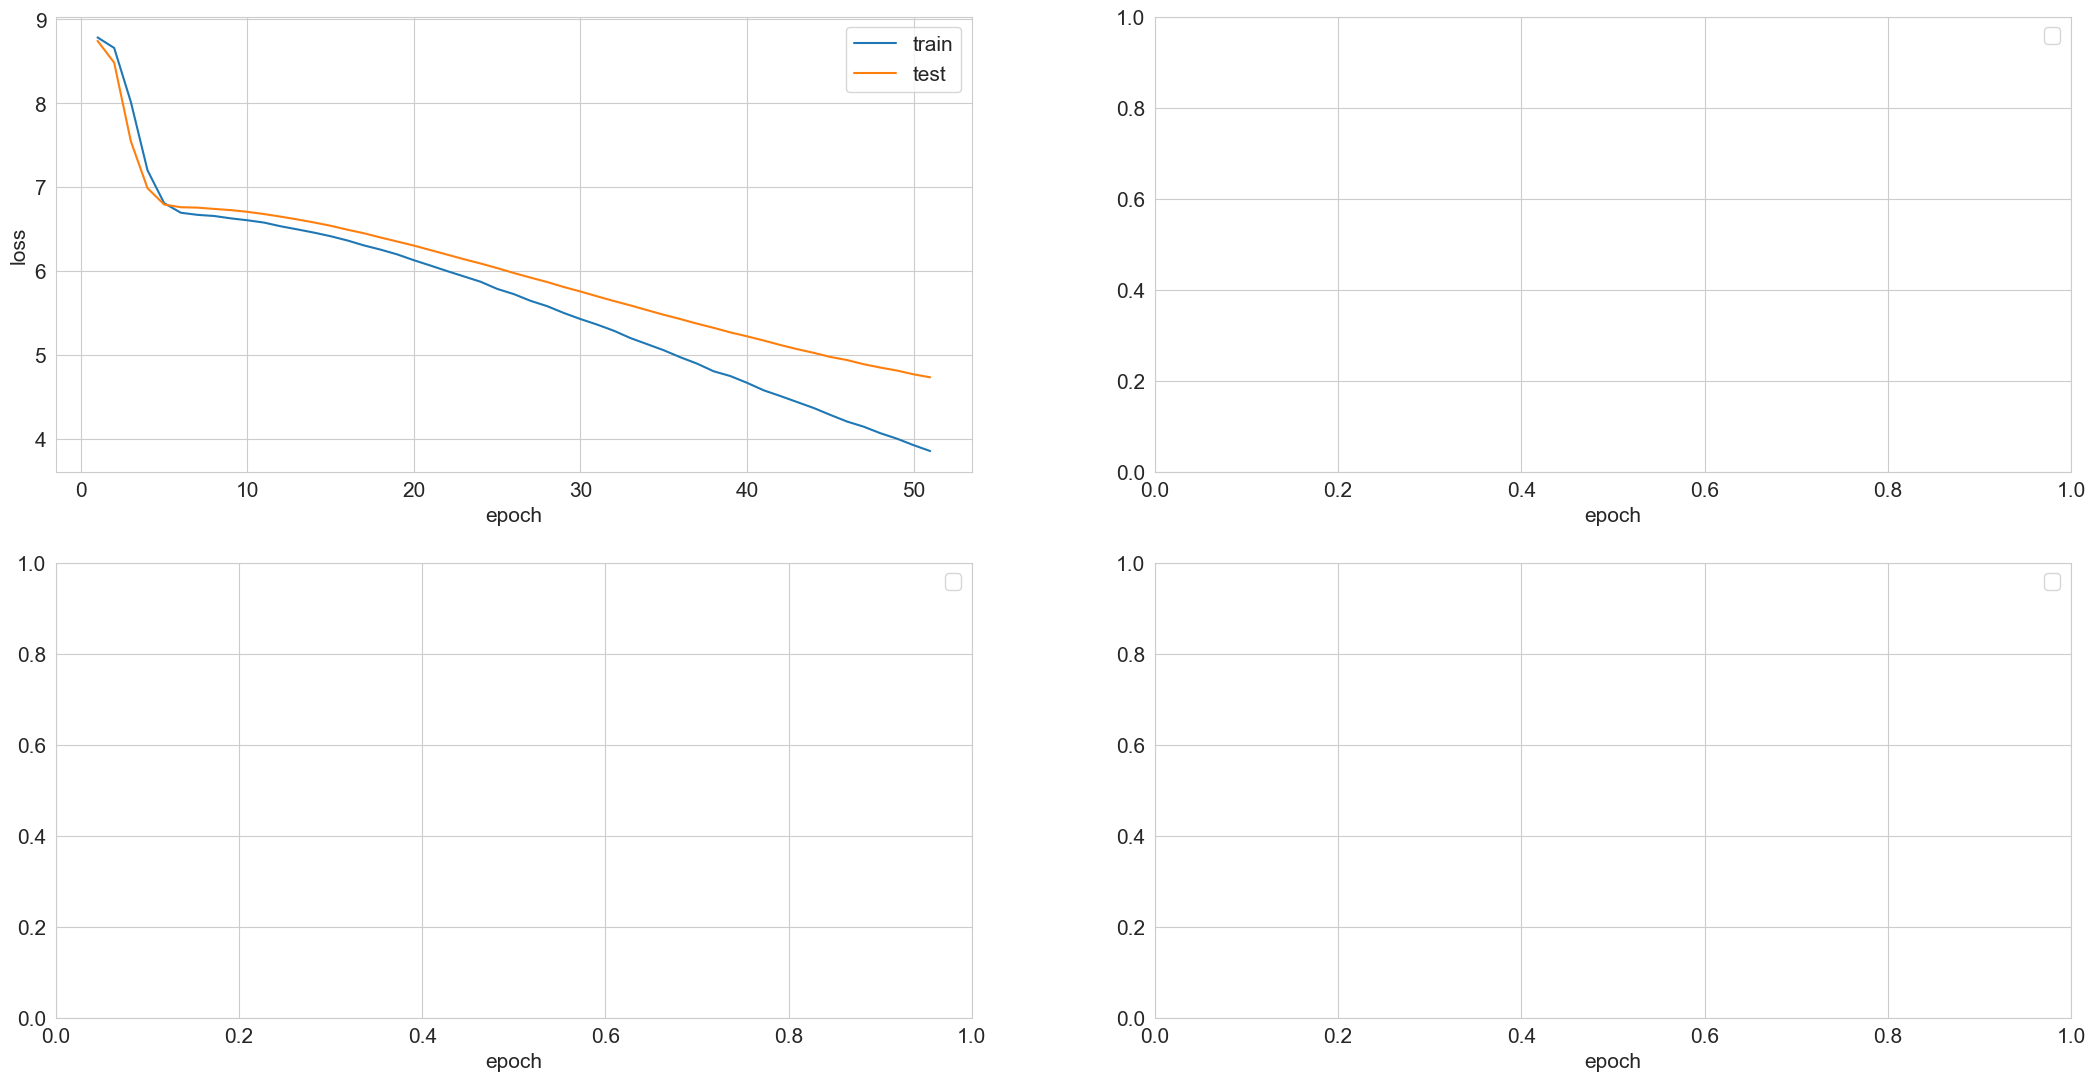

Epoch 51
val metrics
loss 4.7319018840789795

train metrics
loss 3.8526839188167026
--------------------------------------------------
0:03:15.551603


In [38]:
trainer = Trainer(
            model,
            optimizer,
            None,
            criterion,
            accelerator,
            device,
        )

a = datetime.now()
train_losses, test_losses, train_metrics, test_metrics = trainer.train(
            train_loader, val_loader, NUM_EPOCHS, plot=True, calculate_metrics=False, metrics_freq=1000)
b = datetime.now()
print(b - a)

# Prediction  

In [41]:
test_loader = accelerator.prepare_data_loader(DataLoader(test_dataset,
                                             batch_size=1,
                                             shuffle=False,
                                             collate_fn=Collator(),
                                             pin_memory=True,
                                             generator=torch.Generator().manual_seed(SEED),
                                             worker_init_fn=seed_worker)
                                                                )

In [33]:
a = datetime.now()
for batch in tqdm(test_loader):
    #break
    metrics = calculate_bleu_wer(model.cpu(), batch['embed'].cpu(), batch['description'].cpu())
    print(metrics)
b = datetime.now()
print(b - a)
print()

In [65]:
a = datetime.now()
for batch in tqdm(test_loader):
    #break
    metrics = calculate_bleu_wer(model.cpu(), batch['embed'].cpu(), batch['description'].cpu())
    print(metrics)
#     break
b = datetime.now()
print(b - a)
print()

# a = datetime.now()
# for batch in tqdm(test_loader):
#     metrics = calculate_bleu_wer(model.to(device), batch['embed'].to(device), batch['description'].to(device))
#     print(metrics)
# b = datetime.now()
# print(b - a)

  0%|          | 0/60 [00:00<?, ?it/s]

{'BLEU': 0.06640964045008567, 'WER': 0.9686684}
{'BLEU': 0.26800163285991013, 'WER': 5.2826085}
{'BLEU': 2.181304145927349, 'WER': 0.93714285}
{'BLEU': 0.0016773239901110319, 'WER': 0.9748744}
{'BLEU': 2.440315194293301, 'WER': 1.0117648}
{'BLEU': 0.9527407401671417, 'WER': 0.9303483}
{'BLEU': 0.9903417847796372, 'WER': 1.0408163}
{'BLEU': 1.2412717925870447e-06, 'WER': 0.9810606}
{'BLEU': 1.8156533748385064, 'WER': 0.9381443}
{'BLEU': 4.010988328155635, 'WER': 0.976}
{'BLEU': 0.4549774458328352, 'WER': 0.9330855}
{'BLEU': 0.24594660355754758, 'WER': 0.9722222}
{'BLEU': 1.941313255443006, 'WER': 0.98255813}
{'BLEU': 0.5047202210524844, 'WER': 1.5795455}
{'BLEU': 0.39975072288145563, 'WER': 0.9480519}
{'BLEU': 0.07280235252083515, 'WER': 0.9590164}
{'BLEU': 1.5826349340745756, 'WER': 0.9548387}
{'BLEU': 0.35615342843933234, 'WER': 3.5384614}
{'BLEU': 0.8893720110540126, 'WER': 1.1230769}
{'BLEU': 95.77814216168173, 'WER': 0.024844721}
{'BLEU': 0.6320385965619724, 'WER': 3.4634147}
{'BLE

In [86]:
for batch in tqdm(test_loader):
    break

metrics = calculate_bleu_wer(model, batch['embed'], batch['description'])
metrics

In [69]:
# model.to(device);

In [42]:
def visualise_predict(loader: DataLoader,
                      model,
                      tokenizer : Tokenizer,
                      max_length : int = 300,
                      greedy : bool = False) -> None:
    for batch in loader:
        captions = model.caption_image(image_embeds=batch['embed'], max_length=max_length, greedy=greedy)
        print('ИСТИННОЕ ОПИСАНИЕ')
        print(tokenizer.decode(batch['description'][0].detach().cpu().numpy()) + '\n')
        print('СГЕНЕРИРОВАННОЕ ОПИСАНИЕ')
        print(tokenizer.decode(captions[0].detach().cpu().numpy()))
        
        img_path = batch['path'][0]
        img = Image.open(str(img_path)).convert('RGB')
        plt.axis('off')
        plt.imshow(img);
        yield

In [43]:
preds = visualise_predict(test_loader, model, tokenizer)

ИСТИННОЕ ОПИСАНИЕ
salton представляет инновационное решение в мире заботы о вашей обуви : губку для нубука , замши , велюра . не просто инструмент , а ухода , в себе эффективность и мягкость . данная губка и . она обладает уникальной в структуру материала , избавляя его от различных загрязнений и возвращая первозданный вид . влага , грязь , реагенты больше не являются проблемой . забота о вашей обуви станет настоящим удовольствием благодаря этому . средство деликатно , поверхность , восстанавливает её цвет и . ваши изделия из нубука , замши или велюра будут , как после профессиональной чистки . особое внимание удобство использования . губка легко скользит по поверхности , даже самых . ваши кроссовки , ботинки , туфли будут выглядеть аккуратно и . salton , как всегда , заботится о качестве своей продукции . продукт строгий и , благодаря чему стал незаменимым инструментом для всех , кто ценит свои вещи и хочет им жизнь . независимо от условий эксплуатации , ваша обувь сохранит свой идеал

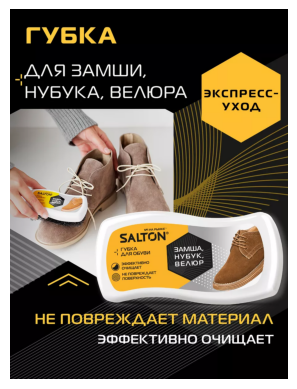

In [44]:
next(preds)

In [45]:
def visualise_predict_beam_search(loader: DataLoader,
                                  model,
                                  tokenizer : Tokenizer,
                                  beam_size : int,
                                  max_length : int = 300) -> None:
    for batch in loader:

        complete_seqs, complete_seqs_scores, uncomplete_seqs, uncomplete_seqs_scores = model.caption_image_beam_search(
                                                                          image_embeds=batch['embed'],
                                                                          beam_size=beam_size,
                                                                          max_length=max_length)
        print('ИСТИННОЕ ОПИСАНИЕ')
        print(tokenizer.decode(batch['description'][0].detach().cpu().numpy()) + '\n')
        print('СГЕНЕРИРОВАННЫЕ ОПИСАНИЯ - ЗАКОНЧЕННЫЕ')
        num_captions = 1
        for caption, score in zip(complete_seqs, complete_seqs_scores):
            for i in range(caption.shape[0]):
                print(f"{num_captions}. " + tokenizer.decode(caption[i].detach().cpu().numpy()) + '\n')
                num_captions += 1
        print('СГЕНЕРИРОВАННЫЕ ОПИСАНИЯ - НЕЗАКОНЧЕННЫЕ')
        num_captions = 1
        for caption, score in zip(uncomplete_seqs, uncomplete_seqs_scores):
            for i in range(caption.shape[0]):
                print(f"{num_captions}. ", tokenizer.decode(caption[i].detach().cpu().numpy()))
                num_captions += 1
            
        img_path = batch['path'][0]
        img = Image.open(str(img_path)).convert('RGB')
        plt.axis('off')
        plt.imshow(img);
        yield

In [51]:
preds = visualise_predict_beam_search(test_loader, model, tokenizer, beam_size=5, max_length=100)

ИСТИННОЕ ОПИСАНИЕ
salton представляет инновационное решение в мире заботы о вашей обуви : губку для нубука , замши , велюра . не просто инструмент , а ухода , в себе эффективность и мягкость . данная губка и . она обладает уникальной в структуру материала , избавляя его от различных загрязнений и возвращая первозданный вид . влага , грязь , реагенты больше не являются проблемой . забота о вашей обуви станет настоящим удовольствием благодаря этому . средство деликатно , поверхность , восстанавливает её цвет и . ваши изделия из нубука , замши или велюра будут , как после профессиональной чистки . особое внимание удобство использования . губка легко скользит по поверхности , даже самых . ваши кроссовки , ботинки , туфли будут выглядеть аккуратно и . salton , как всегда , заботится о качестве своей продукции . продукт строгий и , благодаря чему стал незаменимым инструментом для всех , кто ценит свои вещи и хочет им жизнь . независимо от условий эксплуатации , ваша обувь сохранит свой идеал

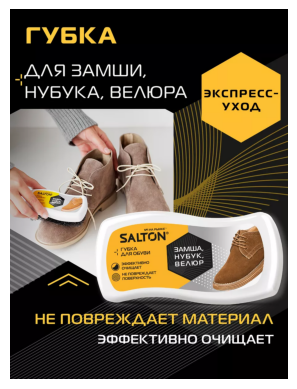

In [52]:
next(preds)